In [9]:
import yfinance as yf
import pandas as pd

#getting data from yfinance
data = yf.download('EURUSD=X', start='2023-08-01', end='2024-08-01')
close = data['Close']

#DataFrame
df = pd.DataFrame(close)
df.reset_index(inplace=True)
print(df)

[*********************100%%**********************]  1 of 1 completed

          Date     Close
0   2023-08-01  1.099759
1   2023-08-02  1.100788
2   2023-08-03  1.094415
3   2023-08-04  1.095158
4   2023-08-07  1.100267
..         ...       ...
256 2024-07-25  1.083952
257 2024-07-26  1.085128
258 2024-07-29  1.085376
259 2024-07-30  1.081947
260 2024-07-31  1.081607

[261 rows x 2 columns]


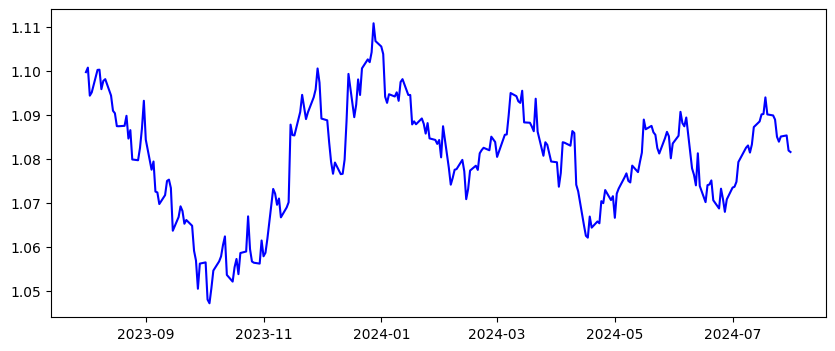

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df['Date'],df['Close'],color = 'blue')


# Split the data in sample and out of sample

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.15, shuffle=False)


# Apply Seasonal trend decomposition aka STL on close prices using statsmodels

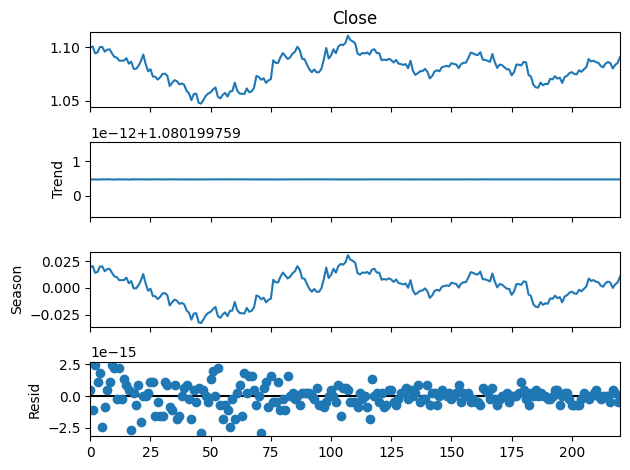

In [12]:
from statsmodels.tsa.seasonal import STL

stl = STL(train['Close'], period=261)
result = stl.fit()

result.plot()
plt.show()